# In-Context Learning: Linear Regression
Adapted from https://intro-to-icl.github.io/

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>

[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/ZerojumpLine.github.io/blob/master/teaching/2025-08-08-Pattern%20Recognition/code_5_icl_regression.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ONWCO15_t2EAZLkH6XPB6x7uNf30WyQI#scrollTo=LNWqepyESWqs)

## **Overview**
This notebook provides a step-by-step walkthrough of an interactive demonstration showing how **Large Language Models (LLMs) can act as optimizers for optimal parameter estimation**. Inspired by recent work positioning LLMs as flexible meta-learners, this experiment uses a simple linear regression setting to investigate whether an LLM can iteratively propose improved parameter values (w, b) by observing model performance, previous attempts, and its own update history. Rather than computing gradients analytically, we allow the LLM—operating purely in non-reasoning mode—to navigate the optimization landscape using only in-context cues.

The goal is to illustrate how an **LLM can behave like a general optimization engine: adjusting parameters, reducing loss,** and **converging towards a solution** after multiple rounds of proposal and feedback.

This demonstration guides you through:
1. Generating synthetic training data from a ground-truth linear function
2. Running an iterative loop where the LLM proposes updated parameters
3. Visualizing the optimization path across iterations
4. Rendering an animation showing the model’s gradual convergence

The result is a clear visualization of how an LLM can perform optimization through pattern-based updates—even in a numerical, regression-style task.

## **Background**

This demo centers on the classic linear regression form:
`y = w⋅x + b`

We generate a small set of 3 points from this ground-truth linear regression line and then give the LLM only the examples of points and a record of previous attempts. The model is not given gradients, derivative formulas, or closed-form solutions. Instead, it receives:
* The training pairs
* Its previous guesses
* The resulting loss values

From this, the model must infer a direction of improvement and produce new (w, b) proposals.

What makes this setup interesting:
* The LLM acts like an optimizer rather than a solver
* The updates depend solely on in-context patterns
* The model relies on recognizing relationships between parameters and loss

This makes it an intuitive testbed for evaluating whether LLMs can learn to optimize through context alone.

## **Let’s Take a Look at an Example**

The visualization below shows:
* The training points used for estimation
* The sequences of candidate regression lines proposed across iterations
* A colorbar indicating iteration step

Each line other than the initial line represents the LLM’s current guess for the underlying linear function.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/linear_regression.gif" height="500">

As the iterations progress, the proposed regression line typically shifts toward the true relationship, demonstrating how the model improves purely based on the examples and the loss given.

## **LLM as the Optimizer**
In this demo, we use qwen-plus in non-reasoning mode. This encourages the model to act not through symbolic derivation, but through pattern recognition and iterative refinement.

The workflow is simple:
- Provide the three (x,y) points
- Supply the model’s current (w, b) guess and its loss
- Ask the model to propose new values that reduce the loss
- Repeat for 30–100 iterations

The LLM becomes an optimization engine—adjusting parameters using only contextual signals. This further highlights the emerging ability of LLMs to perform optimization without explicit algorithmic implementations.

## **Code Overview**
The implementation is organized into a modular structure, with each component responsible for a different stage of the linear regression optimization pipeline. This design separates data loading, visualization, prompt construction, and LLM inference, making the system easy to understand, modify, and extend.

# Install required packages

In [2]:
!pip install numpy
!pip install openai
!pip install scikit-image
!pip install scikit-learn

In [3]:
#@title **Import Necessary Libraries**
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import math
import ast
import getpass
from tqdm import tqdm
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from openai import OpenAI

In [4]:
Qwen_API_Key = "sk-40840707a91d45c0b22585f6c8bfecfb" # this is the API-Key generated by Zeju in Dec 2025.

## Let's first try to use the Qwen API with some simple examples.

In [5]:
client = OpenAI(
    # 若没有配置环境变量，请用百炼API Key将下行替换为：api_key="sk-xxx"
    api_key=Qwen_API_Key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

completion = client.chat.completions.create(
    # 模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
    model="qwen-plus",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who are you？"},
    ]
)
print(completion.model_dump_json())
print("\n提取的文本内容:")
print(completion.choices[0].message.content)

{"id":"chatcmpl-3043ba7b-1f80-4a49-b902-057961e22fa9","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":"Hello! I am Qwen, a large-scale language model independently developed by the Tongyi Lab under Alibaba Group. I can assist you with answering questions, writing, logical reasoning, programming, and more. I can also express opinions and play games. Feel free to let me know if you need any help!","refusal":null,"role":"assistant","annotations":null,"audio":null,"function_call":null,"tool_calls":null}}],"created":1765907176,"model":"qwen-plus","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":62,"prompt_tokens":23,"total_tokens":85,"completion_tokens_details":null,"prompt_tokens_details":{"audio_tokens":null,"cached_tokens":0}}}

提取的文本内容:
Hello! I am Qwen, a large-scale language model independently developed by the Tongyi Lab under Alibaba Group. I can assist you with answering questions, writing, logic

## **Utlity Functions**

Below are the cells that act as the backbone to the entire LLM optimization pipeline.

The cell `Linear Task Randomized Generation` is in charge of generating the linear task the LLM is supposed to predict. It uses the line generated by random values of the slope and intercept to obtain 35 random noisy data points using the line and returns the true slope and intercept, along with the 35 (x, y) pairs

The next cell `Prompt Generation` builds the text prompt given to the LLM during each optimization step. It formats the training point pairs and the history of previous (w, b) guesses with their losses, then inserts them into a structured instruction block. The function returns a prompt that tells the model to propose a better (w, b) and output it strictly as a JSON object.

The following cell `Model Inference` contains a function that sends the generated prompt to the LLM and retrieves its proposed (w, b) values. It calls the model, retries after a delay if a quota error occurs, and then cleans and parses the model’s JSON-only response. Finally, it extracts the "w" and "b" fields from the parsed output and returns them.

In [6]:
#@title **Linear Task Randomized Generation**
def generate_linear_task(noise_ratio=0.2):
    w = np.random.uniform(-5, 5)   # slope
    b = np.random.uniform(-5, 5)   # intercept
    n_train = 35                   # 50 points

    x_train = np.random.uniform(-5, 5, n_train)

    # Clean line
    y_clean = w * x_train + b

    # Scale noise to the signal range (10% of typical variation)
    y_range = np.max(y_clean) - np.min(y_clean)
    noise_std = noise_ratio * y_range

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_train)
    y_train = y_clean + noise

    # Round for readability
    train_pairs = [(round(x, 2), round(y, 2)) for x, y in zip(x_train, y_train)]
    w = round(w, 2)
    b = round(b, 2)
    return train_pairs, w, b

In [7]:
#@title **Prompt Generation**
def generate_optimizer_prompt(train_pairs, history, it):

    history_str = "\n".join([f"(w={w}, b={b}): loss={round(loss,2)}" for w, b, loss in history])

    examples_str = "\n".join([f"({x},{y})" for x, y in train_pairs])

    prompt = f"""
    Here are the (x, y) numerical examples: {examples_str}
    
    Here are the previously tried (w, b) values and their losses: {history_str}
    
    You are currently at iteration {it} of 50.
    
    Your task:
    - Infer a better (w, b) that reduces the loss.
    - Propose exactly one (w, b) pair.
    - Return ONLY a JSON object of the form: {{"w": number, "b": number}}
    
    Do not include any text, explanation, or code.
    """
    
    return prompt

In [8]:
#@title **Model Inference**
def propose_wb(train_pairs, history,it):
    prompt = generate_optimizer_prompt(train_pairs, history,it)
    response = client.chat.completions.create(
        model="qwen-plus",
        messages=[
        {"role": "system", "content": "You are helping to discover the underlying linear relationship y=w*x+b."},
        {"role": "user", "content": prompt},
        ]
    )
    
    cleaned = response.choices[0].message.content

    parsed = ast.literal_eval(cleaned)
    w = parsed["w"]
    b = parsed["b"]
    return w, b

## **Let's look at an example of the prompt**
```
You are trying to discover the underlying linear line from the numerical examples.

Here are the example (x,y) points:
{xy_points}

Previously tried w, b and the loss:
{optimization_history}

You are currently at iteration {it} out of 50

Your task:
- Infer a better (w, b) that reduces the loss.
- Propose exactly one (w, b) pair.
- Return ONLY a JSON object of the form:
  {{"w": number, "b": number}}

Do not include any text, explanation, or code.
```

This prompt shows the model several numerical point pairs along with a running history of previously attempted linear parameters, each associated with its loss. The examples illustrate the points from the true line the model is trying to find, while the optimization history demonstrates how well past guesses have performed. The model’s objective is to infer the underlying linear relationship and propose a better (w,b) that should reduce the loss in the next step.

This is considered ICL because the model is never retrained or fine-tuned; it performs all reasoning directly inside the prompt. The example points and the optimization history act as temporary, in-context supervision that guides the model toward better parameter choices. By interpreting these examples and losses, the model infers the pattern, adjusts its guess, and outputs improved parameters—all within a single forward pass—demonstrating learning from context rather than parameter updates.

The cell below `Main Optimization Loop` runs the full optimization loop where the LLM repeatedly proposes improved values of w and b. It begins by generating a synthetic linear task, computing an initial random guess, and recording its loss; then for each iteration, it calls the LLM to propose a new (w,b), evaluates the loss of that proposed values, and appends the result to the optimization history. After completing all iterations, it returns the training data, the full sequence of guesses, and the true underlying parameters, and finally prints the loss of the last LLM-proposed solution.

In [9]:
#@title **Main Optimization Loop**
from tqdm import tqdm

def compute_loss(train_pairs, w, b):
    xs = np.array([p[0] for p in train_pairs])
    ys = np.array([p[1] for p in train_pairs])
    pred = w * xs + b
    return float(np.mean((pred - ys) ** 2))

train_pairs, w_true, b_true = generate_linear_task()

def run_iterations(n_iterations=50):

    history = []
    w_initial = round(np.random.uniform(-5, 5), 2)
    b_initial = round(np.random.uniform(-5, 5), 2)
    loss_initial = compute_loss(train_pairs, w_initial, b_initial)
    history.append((float(w_initial), float(b_initial), loss_initial))


    # Add tqdm progress bar
    for it in tqdm(range(n_iterations), desc="Optimizing (LLM proposing w,b)"):
        w, b = propose_wb(train_pairs, history, it)
        if w is None or b is None:
            history.append((None, None, 1e9))
            continue

        loss = compute_loss(train_pairs, w, b)
        history.append((float(w), float(b), loss))

    return train_pairs, history, w_true, b_true

n_iterations = 50
train_pairs, history, w_true, b_true = run_iterations(n_iterations)

final_w, final_b, final_loss = history[-1]
print("\nFinal loss:", final_loss)

Optimizing (LLM proposing w,b): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Final loss: 0.7485113365942855


The cell below dispalys a cisualization for how each LLM-proposed (w,b) evolves over the course of the ICL optimization process. It constructs every model-predicted line from the history, assigns each iteration a color on a gradient, and plots the example points provided. Then, using an animation, it draws one fitted line per frame—adding the newest line and shows how the model's guesses gradually move toward the correct linear fit.

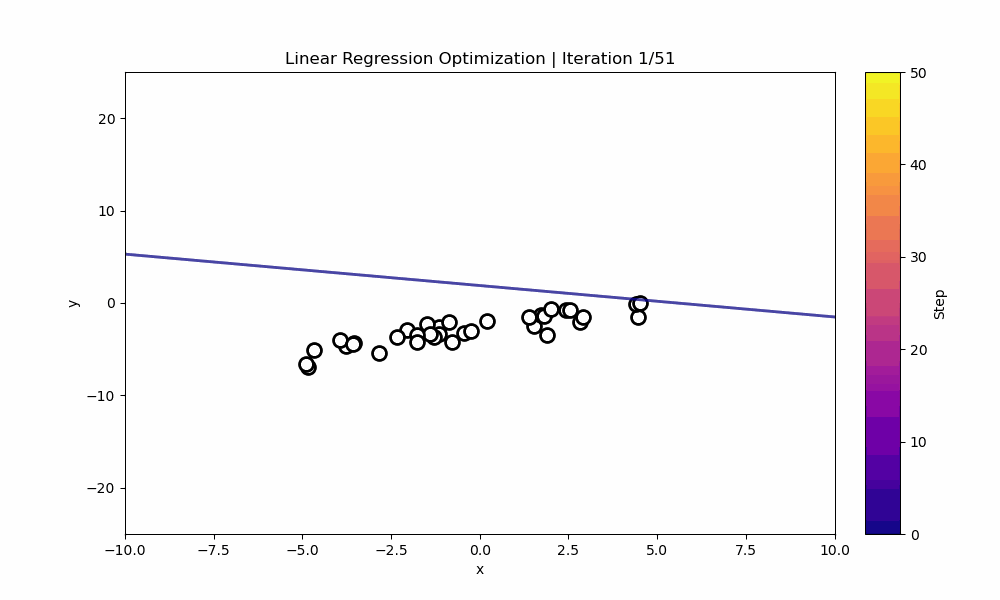

In [10]:
#@title **Linear Regression Optimization Process**
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = np.linspace(-10, 10, 200)
y_true = w_true * x + b_true
model_lines = [(w, b, w * x + b) for (w, b, _) in history]
num_iters = len(model_lines)

cmap = matplotlib.colormaps.get_cmap("plasma")
norm = Normalize(vmin=0, vmax=num_iters - 1)
colors = [cmap(norm(i)) for i in range(num_iters)]

xs = np.array([p[0] for p in train_pairs], dtype=float)
ys = np.array([p[1] for p in train_pairs], dtype=float)

fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(x, y_true, "k--", label="Ground Truth", linewidth=2)
ax.scatter(xs, ys, facecolor='white', edgecolor='black', s=100, linewidths=2)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-25, 25)
ax.set_xlabel("x")
ax.set_ylabel("y")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

cb = plt.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax
)
cb.set_label("Step", rotation=90)

plotted_lines = []

def update(frame):
    w, b, y = model_lines[frame]

    # color for this iteration
    color = colors[frame]

    # newest line (opaque)
    new_line, = ax.plot(x, y, color=color, alpha=0.5, linewidth=2)
    plotted_lines.append(new_line)

    # fade old lines
    for i, line in enumerate(plotted_lines):
        age = len(plotted_lines) - 1 - i
        # line.set_alpha(max(0.1, 1 - age * 0.07))

    ax.set_title(

        f"Linear Regression Optimization | Iteration {frame+1}/{num_iters}"
    )

    return plotted_lines

ani = FuncAnimation(fig, update, frames=num_iters, interval=400, blit=False)
ani.save("linear_regression_optimization_path.gif", writer="pillow", fps=5)

plt.close()
gif_path = "linear_regression_optimization_path.gif"
# Display interactive animation only
display(Image(filename=gif_path))


In [11]:
#@title **Comparison between true slope/intercept values & predicted slope/interecept values**
print(f"Ground Truth - Slope: {w_true}, Intercept: {b_true}")
print(f"Predicted - Slope: {final_w}, Intercept: {final_b}")

Ground Truth - Slope: 0.49, Intercept: -2.54
Predicted - Slope: 0.644, Intercept: -2.379


The cell below then extracts the loss from each optimization step and plots how it changes over time. It creates a simple line plot where the x-axis represents the iteration number and the y-axis shows the corresponding loss value. The resulting figure visualizes whether the LLM’s proposed (w,b) values are improving by showing the trend of the loss across iterations.

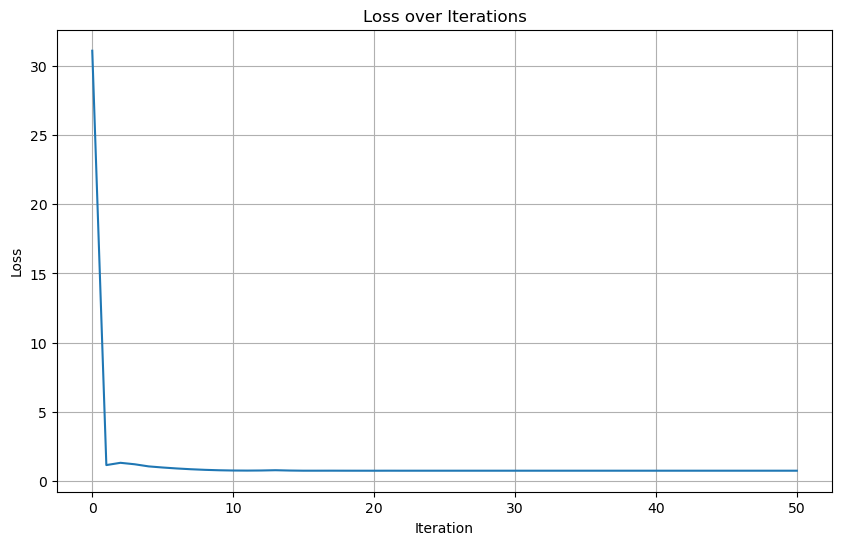

In [12]:
#@title **Visualize Distribution of Loss Over Iterations**

loss_values = [entry[2] for entry in history]

plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.grid(True)
plt.show()


## **Summary**

This demo illustrates how LLMs can perform ICL by iteratively improving a linear line by using only numerical examples and loss feedback contained within the prompt. By presenting a small set of (x,y) pairs along with the history of previously attempted (w,b) values and their losses, the model is encouraged to infer the underlying linear relationship and propose better parameters without any explicit gradient formulas or training loops. Each iteration provides new context—updated guesses and their associated errors—allowing the LLM to adjust its predictions and gradually approach the true line through pattern recognition rather than parameter updates. Through this setup, we observe how the model implicitly learns to reduce error over time, effectively behaving as an optimizer driven purely by context.

Beyond this specific linear regression example, the same methodology can be extended to a broad range of optimization and model-fitting problems. By embedding intermediate states, errors, or constraints into the prompt, LLMs can be guided to improve polynomial fits, tune hyperparameters, refine curve approximations, or even propose solutions to custom objective functions defined by the user. These variations highlight the versatility of the in-context learning paradigm for continuous and numerical reasoning tasks, demonstrating how LLMs can perform iterative improvement when framed through well-structured, example-driven prompts.

## **Conclusion**

This demonstration shows that LLMs can engage in iterative numerical reasoning using only the information supplied in the prompt—capturing the core idea of in-context learning in the setting of linear regression. Without receiving gradients, explicit optimization rules, or model updates, the LLM learns from the pattern of losses and examples to produce increasingly accurate (w,b) values over time. Although the model is not performing true mathematical optimization, its ability to approximate the underlying line through repeated contextual feedback reveals a promising direction for using LLMs as lightweight, prompt-driven optimizers. Linear regression therefore serves as a clear and intuitive example of how LLMs can adapt, refine, and improve numerical predictions purely from context.